# Part 6: K-Means - DBSCAN Clustering

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import shapely
import folium
import seaborn as sns

! pip install lonboard

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
## Task 1 Data Exploration: Load the Chicago parcels dataset using Pandas

file_path = ('/content/drive/MyDrive/Colab Notebooks/data/Chicago_parcels.shp')

parcels_df = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/data/Chicago_parcels.shp')

##Task 2: Display the first few rows of the dataset. Investigae the available attributes and their data types
parcels_df.head()
parcels_df.info()
parcels_df.describe()
parcels_df.dtypes



<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 592521 entries, 0 to 592520
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   POLY_ID   592521 non-null  int64   
 1   ID        592521 non-null  int64   
 2   AREA      592521 non-null  float64 
 3   PIN_OLD   592521 non-null  int64   
 4   PIN       592521 non-null  int64   
 5   geometry  592521 non-null  geometry
dtypes: float64(1), geometry(1), int64(4)
memory usage: 27.1 MB


POLY_ID        int64
ID             int64
AREA         float64
PIN_OLD        int64
PIN            int64
geometry    geometry
dtype: object

In [4]:
## Create a map to visualize the spatial distribution of tax parcel polygons in Chicago. This is a
# dataset with more than a half millions of records, therefore if you use the traditional matplotlib or
#pandas you will reach the RAM limit of Colab, you need to use lonboard library and the
#SolidPolygonLayer layer to render polygons.

import geopandas as gpd
from lonboard import Map, SolidPolygonLayer

parcels_df = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/data/Chicago_parcels.shp')
layer = SolidPolygonLayer.from_geopandas(
    parcels_df,
    get_fill_color=[255, 0, 0],
)
map_ = Map(layers=[layer])

map_

/usr/local/lib/python3.10/dist-packages/lonboard/_layer.py:112: UserWarning: GeoDataFrame being reprojected to EPSG:4326
  warnings.warn("GeoDataFrame being reprojected to EPSG:4326")


Map(layers=[SolidPolygonLayer(get_fill_color=[255, 0, 0], table=pyarrow.Table
POLY_ID: uint32
ID: uint32
AREA:…

In [5]:
## Task 4: Correlation Analysis: Explore correlations between spatial attributes (latitude, longitude) and numerical atrtributes.
## Using the text cell, provide insights into any observed correlations



parcels_df.head()

,POLY_ID,ID,AREA,PIN_OLD,PIN,geometry
0,1,93,0.01,836300010,836300010,"POLYGON ((1091182.694 1942890.287, 1091173.159..."
1,2,94,0.00,836300011,836300011,"POLYGON ((1092430.298 1943191.955, 1092463.452..."
2,3,96,0.02,836300013,836300013,"POLYGON ((1092323.996 1942962.610, 1092301.306..."
3,4,95,0.01,836300012,836300012,"POLYGON ((1092024.119 1942447.762, 1091997.190..."
4,5,92,0.01,836300009,836300009,"POLYGON ((1091970.533 1942338.191, 1091929.082..."


In [6]:
## Task 4: continued

keep_cols = [
    "POLY_ID",
    "geometry",
]

parcels_df = parcels_df[keep_cols]

parcels_df.head()

,POLY_ID,geometry
0,1,"POLYGON ((1091182.694 1942890.287, 1091173.159..."
1,2,"POLYGON ((1092430.298 1943191.955, 1092463.452..."
2,3,"POLYGON ((1092323.996 1942962.610, 1092301.306..."
3,4,"POLYGON ((1092024.119 1942447.762, 1091997.190..."
4,5,"POLYGON ((1091970.533 1942338.191, 1091929.082..."


In [7]:
## Task 4: continued

# I had to look up the following to separate the x,y values of the geometry attribute to get Latitude and Longitude, I tried to follow the spatial clustering guide but could not figure it out
parcels_df['latitude'] = parcels_df['geometry'].centroid.x if parcels_df['geometry'].geom_type[0] == 'Polygon' else parcels_df['geometry'].x
parcels_df['longitude'] = parcels_df['geometry'].centroid.y if parcels_df['geometry'].geom_type[0] == 'Polygon' else parcels_df['geometry'].y

parcels_df.head()

,POLY_ID,geometry,latitude,longitude
0,1,"POLYGON ((1091182.694 1942890.287, 1091173.159...",1.091780e+06,1.943042e+06
1,2,"POLYGON ((1092430.298 1943191.955, 1092463.452...",1.092427e+06,1.943134e+06
2,3,"POLYGON ((1092323.996 1942962.610, 1092301.306...",1.091688e+06,1.942695e+06
3,4,"POLYGON ((1092024.119 1942447.762, 1091997.190...",1.091538e+06,1.942343e+06
4,5,"POLYGON ((1091970.533 1942338.191, 1091929.082...",1.091543e+06,1.942083e+06


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  w

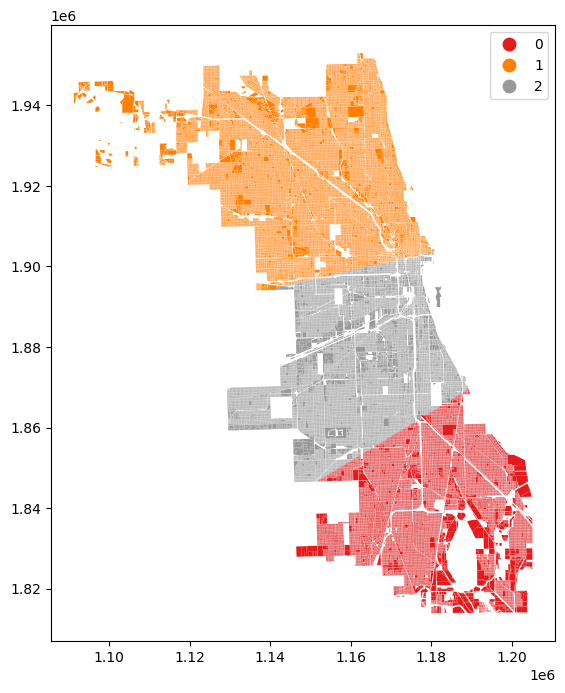

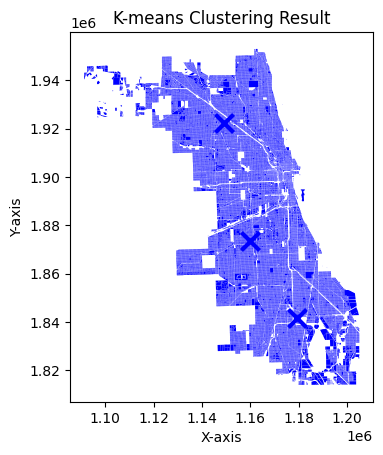

In [8]:
## Task 4: continued
## Task 5: K-Means Clustering: Implement K-Means clustering with different values of n_clusters

numerical_attributes = parcels_df[['latitude', 'longitude']]

kmeans = KMeans(n_clusters = 3, random_state=42)
parcels_df['kmeans_cluster'] = kmeans.fit_predict(numerical_attributes)

parcels_df.plot(column = 'kmeans_cluster', categorical=True, legend=True, figsize=(8,8), cmap= 'Set1')
parcels_df.plot(marker = 'o', color = 'blue')
gpd.points_from_xy

centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="b",
    zorder=10,
)
plt.title('K-means Clustering Result')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  w

<Axes: >

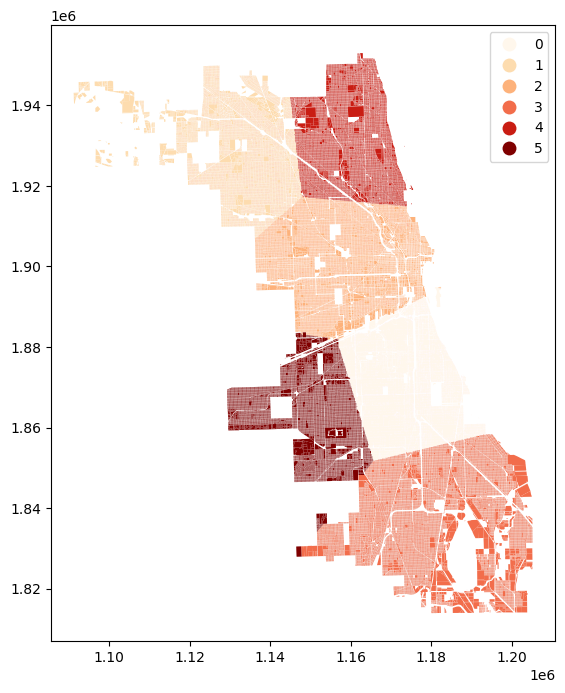

In [11]:
## Task 6: Visualize the clustering results for each value of n_clusters, using multiple lonboard maps, and customized colour ramps

kmeans = KMeans(n_clusters = 6, random_state=42)
parcels_df['kmeans_cluster'] = kmeans.fit_predict(parcels_df[['longitude', 'latitude']])

parcels_df.plot(column = 'kmeans_cluster', categorical = True, legend = True, figsize=(8,8), cmap = 'OrRd')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  w

<Axes: >

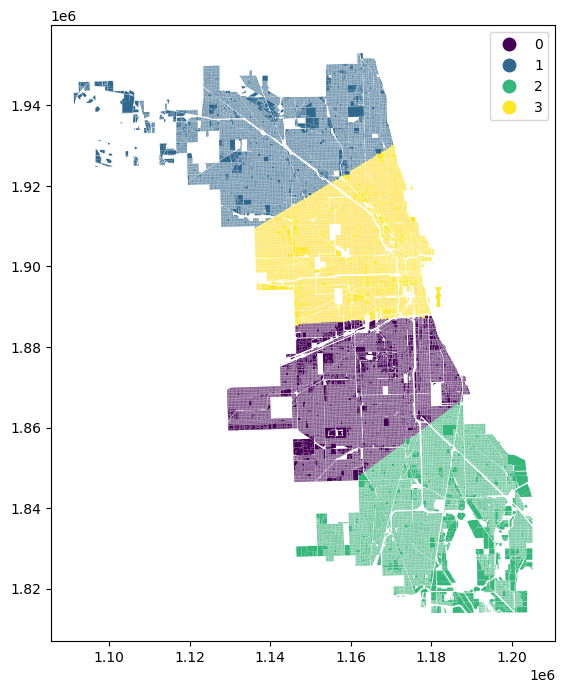

In [13]:
## Task 6: Visualize the clustering results for each value of n_clusters, using multiple lonboard maps, and customized colour ramps

kmeans = KMeans(n_clusters = 4, random_state=42)
parcels_df['kmeans_cluster'] = kmeans.fit_predict(parcels_df[['longitude', 'latitude']])

parcels_df.plot(column = 'kmeans_cluster', categorical = True, legend = True, figsize=(8,8), cmap = 'viridis')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  w

<Axes: >

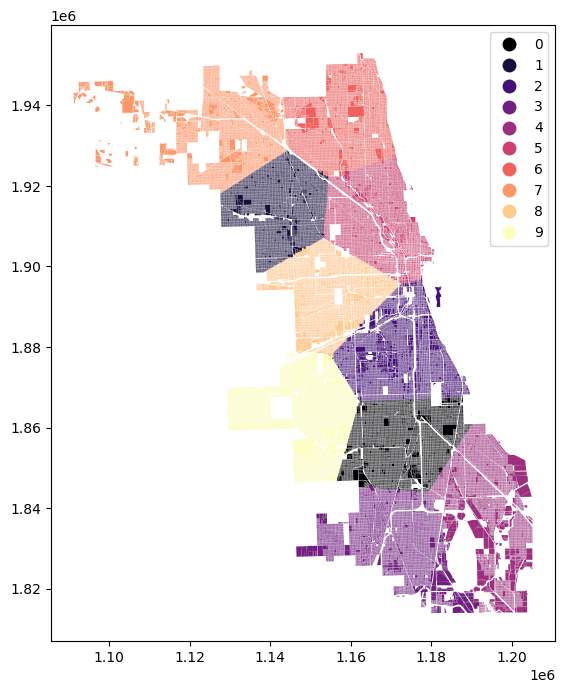

In [14]:
## Task 6: Visualize the clustering results for each value of n_clusters, using multiple lonboard maps, and customized colour ramps

kmeans = KMeans(n_clusters = 10, random_state=42)
parcels_df['kmeans_cluster'] = kmeans.fit_predict(parcels_df[['longitude', 'latitude']])

parcels_df.plot(column = 'kmeans_cluster', categorical = True, legend = True, figsize=(8,8), cmap = 'magma')

Task 7: Evaluate the clustering results and choose an "optimal" value for n_clusters

The ideal value for n_clusters is 6. For n_clusters with a value of 10, there are too many colors and arbitrary divisions. For n_clusters with a value of 4, the areas are split up too equally, which is why 6 is perfect due to the equal division among the areas.